In [174]:
import numpy as np
import tensorflow as tf
import pandas as pd
import pylast
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import json
import random
from sklearn.neighbors import KNeighborsClassifier
import math

# for word to vec
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings
warnings.filterwarnings(action = 'ignore') 
  
import gensim 
from gensim.models import Word2Vec 
import nltk
nltk.download('punkt')


from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder


import scikitplot.plotters as skplt
# from xgboost import XGBClassifier
import os

# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Dense, Embedding, LSTM
# from keras.utils.np_utils import to_categorical
# from keras.callbacks import ModelCheckpoint
# from keras.models import load_model
# from keras.optimizers import Adam

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shuyuanxiao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [170]:
### WITH ORIGINAL DATABASE ###
# lyrics_labels = pd.read_csv("random_tracks_with_lyrics_labels.csv")
# lyrics_labels = lyrics_labels.dropna()
# lyrics_labels = lyrics_labels.reset_index(drop=True)
# lyrics_labels.head()

# lyrics_labels = pd.read_csv("random_tracks_with_lyrics_labels.csv")
# lyrics_labels = lyrics_labels.dropna()
# lyrics_labels = lyrics_labels.reset_index(drop=True)
# lyrics_labels.head()

# for i in range(lyrics_labels.shape[0]):
#     lyr = lyrics_labels.iloc[i]["Lyrics"]
#     lyr = lyr.replace("\n", " ")

In [171]:
### WITH CLEANED DATABASE ###
cleaned_lyrics_labels = pd.read_csv("cleaned_lyrics_labels.csv")
cleaned_lyrics_labels.head()

,Title,Artist,Lyrics,mood
0,Get A Hold,A Tribe Called Quest,Drifting back... suddenly Drifting back (ju...,chill out
1,Electric Relaxation,A Tribe Called Quest,"Relax yourself girl, please set-tle down ...",chill out
2,Check the Rhime,A Tribe Called Quest,"Uh, uh, uh, uh Uh, uh, uh, check the rhyme ...",chill out
3,Juicy,The Notorious B.I.G.,"(""Fuck all you hoes!"" Get a grip, motherfuc...",chill out
4,Full Clip,Gang Starr,"Big L, rest in peace! Do you wanna mess wit...",chill out


In [150]:
moods = cleaned_lyrics_labels[["mood"]]
moods.shape
# cleaned_lyrics_labels['mood'].value_counts().plot(kind="bar", rot=0)

(7094, 1)

In [148]:
# lyrics_vecs = []
# for i in range(cleaned_lyrics_labels.shape[0]):
#     lyr = cleaned_lyrics_labels.iloc[i]["Lyrics"]
    
#     # iterate through each sentence in the file 
#     vecs = [] 
#     for i in sent_tokenize(lyr): 
#         temp = []       
#         # tokenize the sentence into words 
#         for j in word_tokenize(i): 
#             temp.append(j.lower()) 
#         vecs.append(temp)
    
#     # for each song lyrics
# #     model = gensim.models.Word2Vec(data,size=100, window=5, min_count=5, workers=4)
#     model = gensim.models.Word2Vec(data,size=100, window=5, min_count=5)
#     lyrics_vecs.append(np.mean(np.asarray(model1.wv.syn0), axis = 1))

In [120]:
# # Create CBOW model 
# model1 = gensim.models.Word2Vec(data, min_count = 1,  
#                               size = 100, window = 5) 
# # Print results 
# print("Cosine similarity between 'relax' " + 
#                "and 'girl' - CBOW : ", 
#     model1.similarity('relax', 'girl')) 

# # Create Skip Gram model 
# model2 = gensim.models.Word2Vec(data, min_count = 1, size = 100, 
#                                              window = 5, sg = 1) 
  
# # Print results 
# print("Cosine similarity between 'relax' " +
#           "and 'girl' - Skip Gram : ", 
#     model2.similarity('relax', 'girl')) 

In [151]:
# lyrics_vecs = np.array(lyrics_vecs)
# lyrics_vecs.shape

In [152]:
# random_forest_model = RandomForestClassifier(max_features="sqrt", max_depth=10, n_estimators = 1000)
# random_forest_model = random_forest_model.fit(lyrics_vecs, moods)

In [178]:
df_train, df_test = train_test_split(cleaned_lyrics_labels, test_size=0.2, random_state=8, stratify=cleaned_lyrics_labels['mood'])
df_train.shape

(5675, 4)

In [186]:
def evaluate_features(X, y, clf=None):
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds, figsize=(12, 8))


In [157]:
class MySentences(object):

    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):

    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [161]:
w2vec = get_word2vec(
    MySentences(
        df_train['Lyrics'].values, 
        #df_test['Lyrics'].values  
    ),
    'w2vmodel'
)

w2vmodel not found. training model
Model done training. Saving to disk


In [162]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [172]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(df_train['Lyrics'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished


Log loss: 1.5531698910201825
Accuracy: 0.47894273127753306


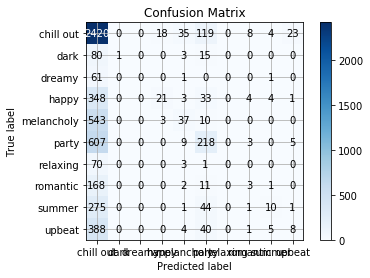

In [175]:
evaluate_features(mean_embedded, df_train['mood'].values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.6s finished


Log loss: 1.013353654811758
Accuracy: 0.7164757709251102


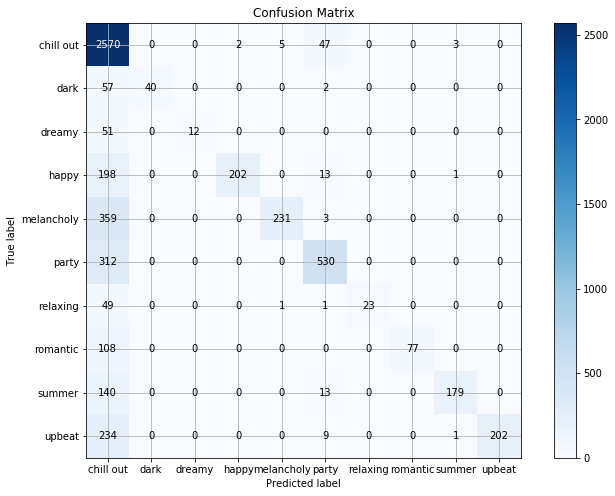

In [187]:
evaluate_features(mean_embedded, df_train['mood'].values.ravel(),
                  RandomForestClassifier(n_estimators=1000, max_depth=20, verbose=1))

In [185]:
cleaned_lyrics_labels.head()

,Title,Artist,Lyrics,mood
0,Get A Hold,A Tribe Called Quest,Drifting back... suddenly Drifting back (ju...,chill out
1,Electric Relaxation,A Tribe Called Quest,"Relax yourself girl, please set-tle down ...",chill out
2,Check the Rhime,A Tribe Called Quest,"Uh, uh, uh, uh Uh, uh, uh, check the rhyme ...",chill out
3,Juicy,The Notorious B.I.G.,"(""Fuck all you hoes!"" Get a grip, motherfuc...",chill out
4,Full Clip,Gang Starr,"Big L, rest in peace! Do you wanna mess wit...",chill out


In [197]:
df1 = cleaned_lyrics_labels[cleaned_lyrics_labels['mood'] == "chill out"]
df2 = cleaned_lyrics_labels[cleaned_lyrics_labels['mood'] == "melancholy"]
df3 = cleaned_lyrics_labels[cleaned_lyrics_labels['mood'] == "happy"]
df4 = cleaned_lyrics_labels[cleaned_lyrics_labels['mood'] == "romantic"]
df5 = cleaned_lyrics_labels[cleaned_lyrics_labels['mood'] == "upbeat"]
df6 = cleaned_lyrics_labels[cleaned_lyrics_labels['mood'] == "dark"]
df7 = cleaned_lyrics_labels[cleaned_lyrics_labels['mood'] == "dreamy"]
df8 = cleaned_lyrics_labels[cleaned_lyrics_labels['mood'] == "party"]
df9 = cleaned_lyrics_labels[cleaned_lyrics_labels['mood'] == "relaxing"]
df10 = cleaned_lyrics_labels[cleaned_lyrics_labels['mood'] == "summer"]

In [199]:
songs_cill_out = df1.sample(n=10, random_state=1)
songs_cmelancholy = df2.sample(n=10, random_state=1)
songs_happy = df3.sample(n=10, random_state=1)
songs_romantic = df4.sample(n=10, random_state=1)
songs_upbeat = df5.sample(n=10, random_state=1)
songs_dark = df6.sample(n=10, random_state=1)
songs_dreamy = df7.sample(n=10, random_state=1)
songs_party = df8.sample(n=10, random_state=1)
songs_relaxing = df9.sample(n=10, random_state=1)
songs_summer = df10.sample(n=10, random_state=1)

In [ ]:
### Other TF-IDF by WEIRU ###
# Train-test split

#cleaned_lyrics_labels_train, _ = train_test_split(cleaned_lyrics_labels, test_size=0.2, random_state=209, stratify=cleaned_lyrics_labels['mood'])

In [210]:
# import matplotlib.pyplot as plt

# from sklearn.model_selection import cross_val_predict
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import log_loss, accuracy_score
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.svm import SVC
# from sklearn.decomposition import TruncatedSVD
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import LabelEncoder

# import gensim

# import scikitplot as skplt

# import nltk

# #from xgboost import XGBClassifier

# import os

# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Dense, Embedding, LSTM
# from keras.utils.np_utils import to_categorical
# from keras.callbacks import ModelCheckpoint
# from keras.models import load_model
# from keras.optimizers import Adam


# count_vectorizer = TfidfVectorizer(
#     analyzer="word", tokenizer=nltk.word_tokenize,
#     preprocessor=None, stop_words='english', max_features=None)    

# tfidf = count_vectorizer.fit_transform(cleaned_lyrics_labels_train['Lyrics'])

# len(count_vectorizer.get_feature_names())

In [202]:
# svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
# truncated_tfidf = svd.fit_transform(tfidf)

In [206]:
# def evaluate_features(X, y, clf=None):
#     """General helper function for evaluating effectiveness of passed features in ML model
    
#     Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
#     Args:
#         X (array-like): Features array. Shape (n_samples, n_features)
        
#         y (array-like): Labels array. Shape (n_samples,)
        
#         clf: Classifier to use. If None, default Log reg is use.
#     """
#     if clf is None:
#         clf = LogisticRegression()
    
#     probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
#                               n_jobs=-1, method='predict_proba', verbose=2)
#     pred_indices = np.argmax(probas, axis=1)
#     classes = np.unique(y)
#     preds = classes[pred_indices]
#     print('Log loss: {}'.format(log_loss(y, probas)))
#     print('Accuracy: {}'.format(accuracy_score(y, preds)))
#     skplt.metrics.plot_confusion_matrix(y, preds, figsize=(12,8))
#     skplt.metrics.plot_precision_recall_curve(y, probas, figsize=(12,8))
#     plt.show()


# evaluate_features(truncated_tfidf, cleaned_lyrics_labels_train['mood'].values.ravel())

In [207]:
# evaluate_features(truncated_tfidf, cleaned_lyrics_labels_train['mood'].values.ravel(), 
#                   RandomForestClassifier(n_estimators=1000, max_depth=25, verbose=1))

In [208]:
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier

# evaluate_features(truncated_tfidf, cleaned_lyrics_labels_train['mood'].values.ravel(), 
#                   AdaBoostClassifier(algorithm='SAMME.R', base_estimator=DecisionTreeClassifier(max_depth=25),
#         learning_rate=1.0, n_estimators=1000, random_state=209))

In [209]:
# evaluate_features(tfidf, cleaned_lyrics_labels_train['mood'].values.ravel(), 
#                   SVC(kernel='linear', probability=True))